In [1]:
from functions import *
from scipy.optimize import linear_sum_assignment

In [ ]:
jax.config.update("jax_debug_nans", True) 

In [2]:
# Define parameters 
num_monomers = 20 
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10

In [3]:
def generate_posterior_parallelize(templates_flatten, observations_flatten, template_weights):
    """
    """ 
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
        
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        ll = loglikelihood(o, t, measurement_error, num_probes)
        lp = logprior(t, num_probes)
        # jax.debug.print("{x}, {y}", x=t, y=lp)
        lw = jnp.log(jnp.abs(alpha)) + 1e-32
        lwp = jnp.log(weight_prior)
        
        rhs = jnp.array([ll, lp, lw, lwp])
        
        # mantissa = jnp.log10(jnp.abs(rhs)) - jnp.floor(jnp.log10(jnp.abs(rhs)))
        # Use absolute value to not care because only the value matters ?
        # jax.debug.print("{z}, {x}", z=alpha, x = log_scale_rhs_max)
        # jax.debug.print("{y}, {z}, {x}, {a}", y= t_ind, z=o_ind, x = log_scale_rhs_max, a=log_scale_rhs)
        # mantissa = jnp.sign(rhs) * mantissa

        
        # val = jnp.sum(mantissa)
        
        val = jnp.sum(rhs)
        
        return val 
    
    def calculate_posterior(i):
        # jax.debug.print("{x}", x=curr_obs_list.shape)
        # jax.debug.print("{y} {x}", y=i, x=jnp.sum(jnp.isnan(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))))
        # jax.debug.print("{z} {x} {y}", z=i, x=jnp.where(o_ind == i, curr_obs_list, -jnp.inf), y=jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf)))
        
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))
    # print(total_posterior)

    return total_posterior

def structure_neg_objective_parallelize(templates):
    """
    """ 
    template_weights = num_observation_list
    # jax.debug.print("{x}", x=-generate_posterior_parallelize(templates, observations_flatten, template_weights))
    
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)

def prediction_error(predicted_flat_dmaps, true_flat_dmaps):
    err = cdist(predicted_flat_dmaps, true_flat_dmaps)/num_monomers**2
    r, c = linear_sum_assignment(err)
    return err[r, c].mean()

def generate_distance_map(chain):
    # Step 1: Compute the squared differences
    diff = chain[:, jnp.newaxis, :] - chain[jnp.newaxis, :, :]
    squared_diff = jnp.square(diff)

    # Step 2: Sum over the feature dimension to get squared distances
    squared_distances = jnp.sum(squared_diff, axis=-1)

    # Step 3: Take the square root to get the Euclidean distances
    distances = jnp.sqrt(squared_distances)
    return distances

def pdist2(vec1, vec2):
    vec1 = jnp.array(vec1)
    vec2 = jnp.array(vec2)
    
    diff = vec1[:, jnp.newaxis, :] - vec2[jnp.newaxis, :, :]
    squared_diff = jnp.square(diff)
    
    squared_distances = jnp.sum(squared_diff, axis=-1)
    
    distance_matrix = jnp.sqrt(squared_distances)
    return distance_matrix

def generate_gaussian_chain_jax(num_monomers: int, 
                            mean_bond_length: float, 
                            std_bond_length: float,
                            random_key: int = None):
    """Generate a Gaussian chain polymer 
    
    Parameters
    ----------
    num_monomers
    mean_bond_length
    std_bond_length
    
    Return
    ------
    np.array 
    
    Notes
    -----
    """ 
    # Generate PRNG key
    # Create an initial PRNG key
    if random_key is None:
        random_key = jax.random.PRNGKey(42)
    
    # Generate steps: each step is a 3D vector 
    steps = mean_bond_length + std_bond_length * jax.random.normal(random_key, shape=(num_monomers, 3))

    # Compute positions by cumulative sum of steps
    positions = jnp.cumsum(steps, axis=0)
    
    return positions

def generate_observations_jax(polymer_chain, num_observations, gaussian_noise_std, random_key):
    """ Given a template polymer chain, generate num_observations polymer chains by adding 
    some gaussian noise to the polymer chain
    
    Parameters
    ----------
    polymer_chain
    num_observations
    gaussian_noise_std
    random_key
    
    Return
    ------
    """
    num_monomers = polymer_chain.shape[0] 
    
    
    # Parameters for Gaussian noise 
    mean = 0 
    std = gaussian_noise_std
    
    # Generate noise profile
    # jax.debug.print('{x}', x=jax.random.normal(key=random_key, shape=(num_observations, num_monomers, 3)))
    noise = mean + std * jax.random.normal(key=random_key, shape=(num_observations, num_monomers, 3))
        
    # Add noise to the original data
    noisy_data = polymer_chain + noise 
    
    return noisy_data

def simulation(k):
    num_models = num_templates
    init_model = [generate_gaussian_chain_jax(num_monomers, mean_bond_length, std_bond_length, k) for m in range(num_models)]
    init_model = [jnp.ravel(generate_distance_map(m)) for m in init_model]
    
    pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=False)
    pg_sol = pg.run(init_model)
    
    dmaps_flat = [generate_flatten_distance_map(x) for x in template_chain_list]
    error_matrix = pdist2(pg_sol.params, dmaps_flat)
    return error_matrix

In [7]:
np.logspace(0, 2, 3)

array([  1.,  10., 100.])

In [6]:
# Change the number of templates
error_matrices = []
times = []


num_iters = 100


measurement_error = gaussian_noise_std
num_probes = num_monomers

key = jax.random.PRNGKey(42)
keys = jax.random.split(key, num_iters)
for x in tqdm(np.logspace(0, 2, 3)):
    start_time = time.time()
    num_templates = int(x)
    template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
    max_observation_number = 100
    num_observation_list = np.random.randint(1, high=max_observation_number, size=num_templates) 
    observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]
    observation_list = np.concatenate([*observation_list])
    observation_class_list = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
    observations_flatten = jnp.array([generate_flatten_distance_map(t) for t in observation_list])
    error_matrices.append(jax.vmap(simulation, in_axes=0)(keys))
    end_time = time.time()
    loop_time = end_time - start_time
    times.append(loop_time)

  0%|          | 0/3 [00:00<?, ?it/s]

2024-06-12 14:45:00.747420: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 942.50GiB (rounded to 1012004184320)requested by op 
2024-06-12 14:45:00.747601: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2024-06-12 14:45:00.748658: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2410] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1012004184184 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   30.52MiB
              constant allocation:   22.86MiB
        maybe_live_out allocation:   30.52MiB
     preallocated temp allocation:  942.50GiB
  preallocated temp fragmentation:        96B (0.00%)
                 total allocation:  942.58GiB
              

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1012004184184 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   30.52MiB
              constant allocation:   22.86MiB
        maybe_live_out allocation:   30.52MiB
     preallocated temp allocation:  942.50GiB
  preallocated temp fragmentation:        96B (0.00%)
                 total allocation:  942.58GiB
              total fragmentation:   53.41MiB (0.01%)
Peak buffers:
	Buffer 1:
		Size: 929.09GiB
		Operator: op_name="jit(update)/jit(main)/reduce_max[axes=(2,)]" source_file="/tmp/ipykernel_1396886/3433170373.py" source_line=55
		XLA Label: fusion
		Shape: f32[100,4994,499400]
		==========================

	Buffer 2:
		Size: 13.21GiB
		Operator: op_name="jit(update)/jit(main)/transpose(jvp(vmap(jit(_where))))/reduce_sum[axes=(1,)]" source_file="/tmp/ipykernel_1396886/3433170373.py" source_line=55
		XLA Label: fusion
		Shape: f32[100,71,499400]
		==========================

	Buffer 3:
		Size: 190.51MiB
		Operator: op_name="jit(update)/jit(main)/jvp(vmap(jit(logprior)))/jit(logprior_)/reduce_sum[axes=(2,)]" source_file="/mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/functions.py" source_line=387
		XLA Label: fusion
		Shape: f32[100,499400]
		==========================

	Buffer 4:
		Size: 15.26MiB
		Operator: op_name="jit(update)/jit(main)/concatenate[dimension=1]" source_file="/tmp/ipykernel_1396886/3433170373.py" source_line=4
		XLA Label: fusion
		Shape: f32[100,100,400]
		==========================

	Buffer 5:
		Size: 7.62MiB
		XLA Label: constant
		Shape: f32[4994,400]
		==========================

	Buffer 6:
		Size: 7.62MiB
		XLA Label: constant
		Shape: f32[4994,400]
		==========================

	Buffer 7:
		Size: 7.62MiB
		XLA Label: constant
		Shape: f32[4994,400]
		==========================

	Buffer 8:
		Size: 1.90MiB
		Operator: op_name="jit(update)/jit(main)/reduce_sum[axes=(2,)]" source_file="/tmp/ipykernel_1396886/3433170373.py" source_line=55
		XLA Label: reduce
		Shape: f32[100,4994]
		==========================

	Buffer 9:
		Size: 1.90MiB
		Operator: op_name="jit(update)/jit(main)/reduce_max[axes=(2,)]" source_file="/tmp/ipykernel_1396886/3433170373.py" source_line=55
		XLA Label: fusion
		Shape: f32[100,4994]
		==========================

	Buffer 10:
		Size: 156.2KiB
		Operator: op_name="jit(update)/jit(main)/jit(<unnamed wrapped function>)/while[cond_nconsts=204 body_nconsts=201]" source_file="/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/loop.py" source_line=60
		XLA Label: fusion
		Shape: f32[100,400]
		==========================

	Buffer 11:
		Size: 156.2KiB
		Operator: op_name="jit(update)/jit(main)/jit(<unnamed wrapped function>)/while[cond_nconsts=204 body_nconsts=201]" source_file="/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/loop.py" source_line=60
		XLA Label: fusion
		Shape: f32[100,400]
		==========================

	Buffer 12:
		Size: 156.2KiB
		Operator: op_name="jit(update)/jit(main)/jit(<unnamed wrapped function>)/while[cond_nconsts=204 body_nconsts=201]" source_file="/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/loop.py" source_line=60
		XLA Label: fusion
		Shape: f32[100,400]
		==========================

	Buffer 13:
		Size: 156.2KiB
		Operator: op_name="jit(update)/jit(main)/jit(<unnamed wrapped function>)/while[cond_nconsts=204 body_nconsts=201]" source_file="/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/loop.py" source_line=60
		XLA Label: fusion
		Shape: f32[100,400]
		==========================

	Buffer 14:
		Size: 156.2KiB
		Operator: op_name="jit(update)/jit(main)/jit(<unnamed wrapped function>)/while[cond_nconsts=204 body_nconsts=201]" source_file="/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/loop.py" source_line=60
		XLA Label: fusion
		Shape: f32[100,400]
		==========================

	Buffer 15:
		Size: 156.2KiB
		Operator: op_name="jit(update)/jit(main)/jit(<unnamed wrapped function>)/while[cond_nconsts=204 body_nconsts=201]" source_file="/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/loop.py" source_line=60
		XLA Label: fusion
		Shape: f32[100,400]
		==========================



In [4]:
# Change the number of observations

error_matrices = []
times = []

num_templates = 10
num_iters = 100

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]

measurement_error = gaussian_noise_std
num_probes = num_monomers

key = jax.random.PRNGKey(42)
keys = jax.random.split(key, num_iters)
for x in tqdm(jnp.logspace(0, 3, 4)):
    start_time = time.time()
    max_observation_number = x+1
    num_observation_list = np.random.randint(1, high=max_observation_number, size=num_templates) 
    observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]
    observation_list = np.concatenate([*observation_list])
    observation_class_list = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
    observations_flatten = jnp.array([generate_flatten_distance_map(t) for t in observation_list])
    error_matrices.append(jax.vmap(simulation, in_axes=0)(keys))
    end_time = time.time()
    loop_time = end_time - start_time
    times.append(loop_time)

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


  0%|          | 0/4 [00:00<?, ?it/s]

2024-06-12 14:33:05.160516: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.31 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-12 14:33:10.979127: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 6.818691637s
Constant folding an instruction is taking > 1s:

  reduce.31 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't n

In [18]:
norm_error_matrices = []
for sample in tqdm(error_matrices):
    err_list = []
    for s in sample:
        err = s/(num_monomers ** 2)
        r, c = linear_sum_assignment(err)
        err_list.append(float(err[r, c].mean()))
    norm_error_matrices.append(err_list)
    
norm_error_matrices = np.array(norm_error_matrices)

  0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
dmaps_flat = np.array([generate_flatten_distance_map(x) for x in template_chain_list])

In [20]:
# Function to calculate bootstrap samples
def bootstrap(data, n_bootstrap):
    n = len(data)
    bootstrap_samples = np.random.choice(data, size=(n_bootstrap, n), replace=True)
    return bootstrap_samples

# Function to calculate the bootstrap mean
def bootstrap_mean(data, n_bootstrap):
    samples = bootstrap(data, n_bootstrap)
    return np.mean(samples, axis=1)

# Number of bootstrap samples
n_bootstrap = 10000


In [39]:
bootstrap_CI_list = []

for x in norm_error_matrices:
    # Calculate bootstrap means
    bootstrap_means = bootstrap_mean(x, n_bootstrap)

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_means, 2.5)
    upper_bound = np.percentile(bootstrap_means, 97.5)
    confidence_interval = (upper_bound-x.mean(), x.mean()-lower_bound)
    
    bootstrap_CI_list.append(confidence_interval)
    
bootstrap_CI_list = np.array(bootstrap_CI_list).T

In [40]:
np.array(bootstrap_CI_list)

array([[0.05578934, 0.03983368, 0.03994852, 0.04458186],
       [0.05131484, 0.03748704, 0.03942414, 0.04198895]])

In [41]:
centroid = np.mean(dmaps_flat, axis=0)
max_error = np.mean(np.sqrt(np.sum((centroid - dmaps_flat)**2, axis=-1)))/num_monomers**2

In [42]:
max_error

1.6283751095536723

In [43]:
norm_error_matrices.mean(axis=1)

array([1.31341967, 1.21064688, 1.1760643 , 1.21422998])

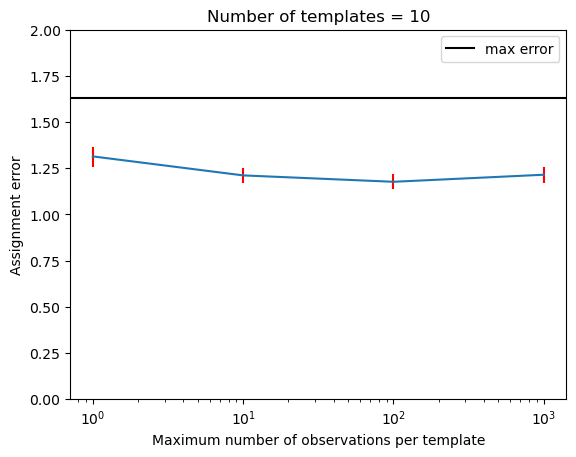

In [55]:
plt.errorbar(jnp.logspace(0, 3, 4), norm_error_matrices.mean(axis=1), yerr=bootstrap_CI_list, ecolor='red')
plt.axhline(max_error, color='black', label='max error')
plt.ylim([0, 2])
plt.xscale('log')
plt.xlabel('Maximum number of observations per template')
plt.ylabel('Assignment error')
plt.title('Number of templates = 10')
plt.legend()